# Single Neuron Logistic Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Naiwen1997/IDNE-577-Machine-Learning/blob/master/Supervised%20Learning/Parametric%20Modeling/Lecture%203%20Single%20Neuron%20Logistic%20Regression/Logistic_Regression.ipynb)

In [48]:
# !pip install ucimlrepo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# import the dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 

# data (as pandas dataframes) 
X = rice_cammeo_and_osmancik.data.features.values
y = rice_cammeo_and_osmancik.data.targets.values

In [49]:
df_var=rice_cammeo_and_osmancik.variables
var_name=df_var['name']
# Convert each entry of y with Cammeo to 1 and otherwise -1, which is the sign function
y=np.where(y=='Cammeo',1,0)
# Standardize the value of X
X=np.array([X[:,i]/X[:,i].max() for i in range(X.shape[1])]).T
# concatenate X and y
data = np.concatenate((X,y),axis=1)
# generate the Dataframe
df=pd.DataFrame(data,columns=var_name)

In [50]:
df

name,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,0.805319,0.958306,0.961254,0.791258,0.979826,0.817687,0.665346,1.0
1,0.774917,0.901294,0.861971,0.852975,0.944513,0.789151,0.714751,1.0
2,0.773754,0.913713,0.895805,0.816127,0.962143,0.782973,0.805132,1.0
3,0.696664,0.835712,0.808908,0.813152,0.940775,0.699932,0.744056,1.0
4,0.776609,0.924735,0.885917,0.830486,0.956418,0.799099,0.750275,1.0
...,...,...,...,...,...,...,...,...
3805,0.604928,0.758248,0.713302,0.797421,0.911682,0.608828,0.790909,0.0
3806,0.614657,0.768335,0.701705,0.831881,0.892240,0.623279,0.806317,0.0
3807,0.657590,0.806823,0.768054,0.807142,0.929470,0.662077,0.727877,0.0
3808,0.522498,0.715288,0.674422,0.727252,0.922363,0.528666,0.765419,0.0


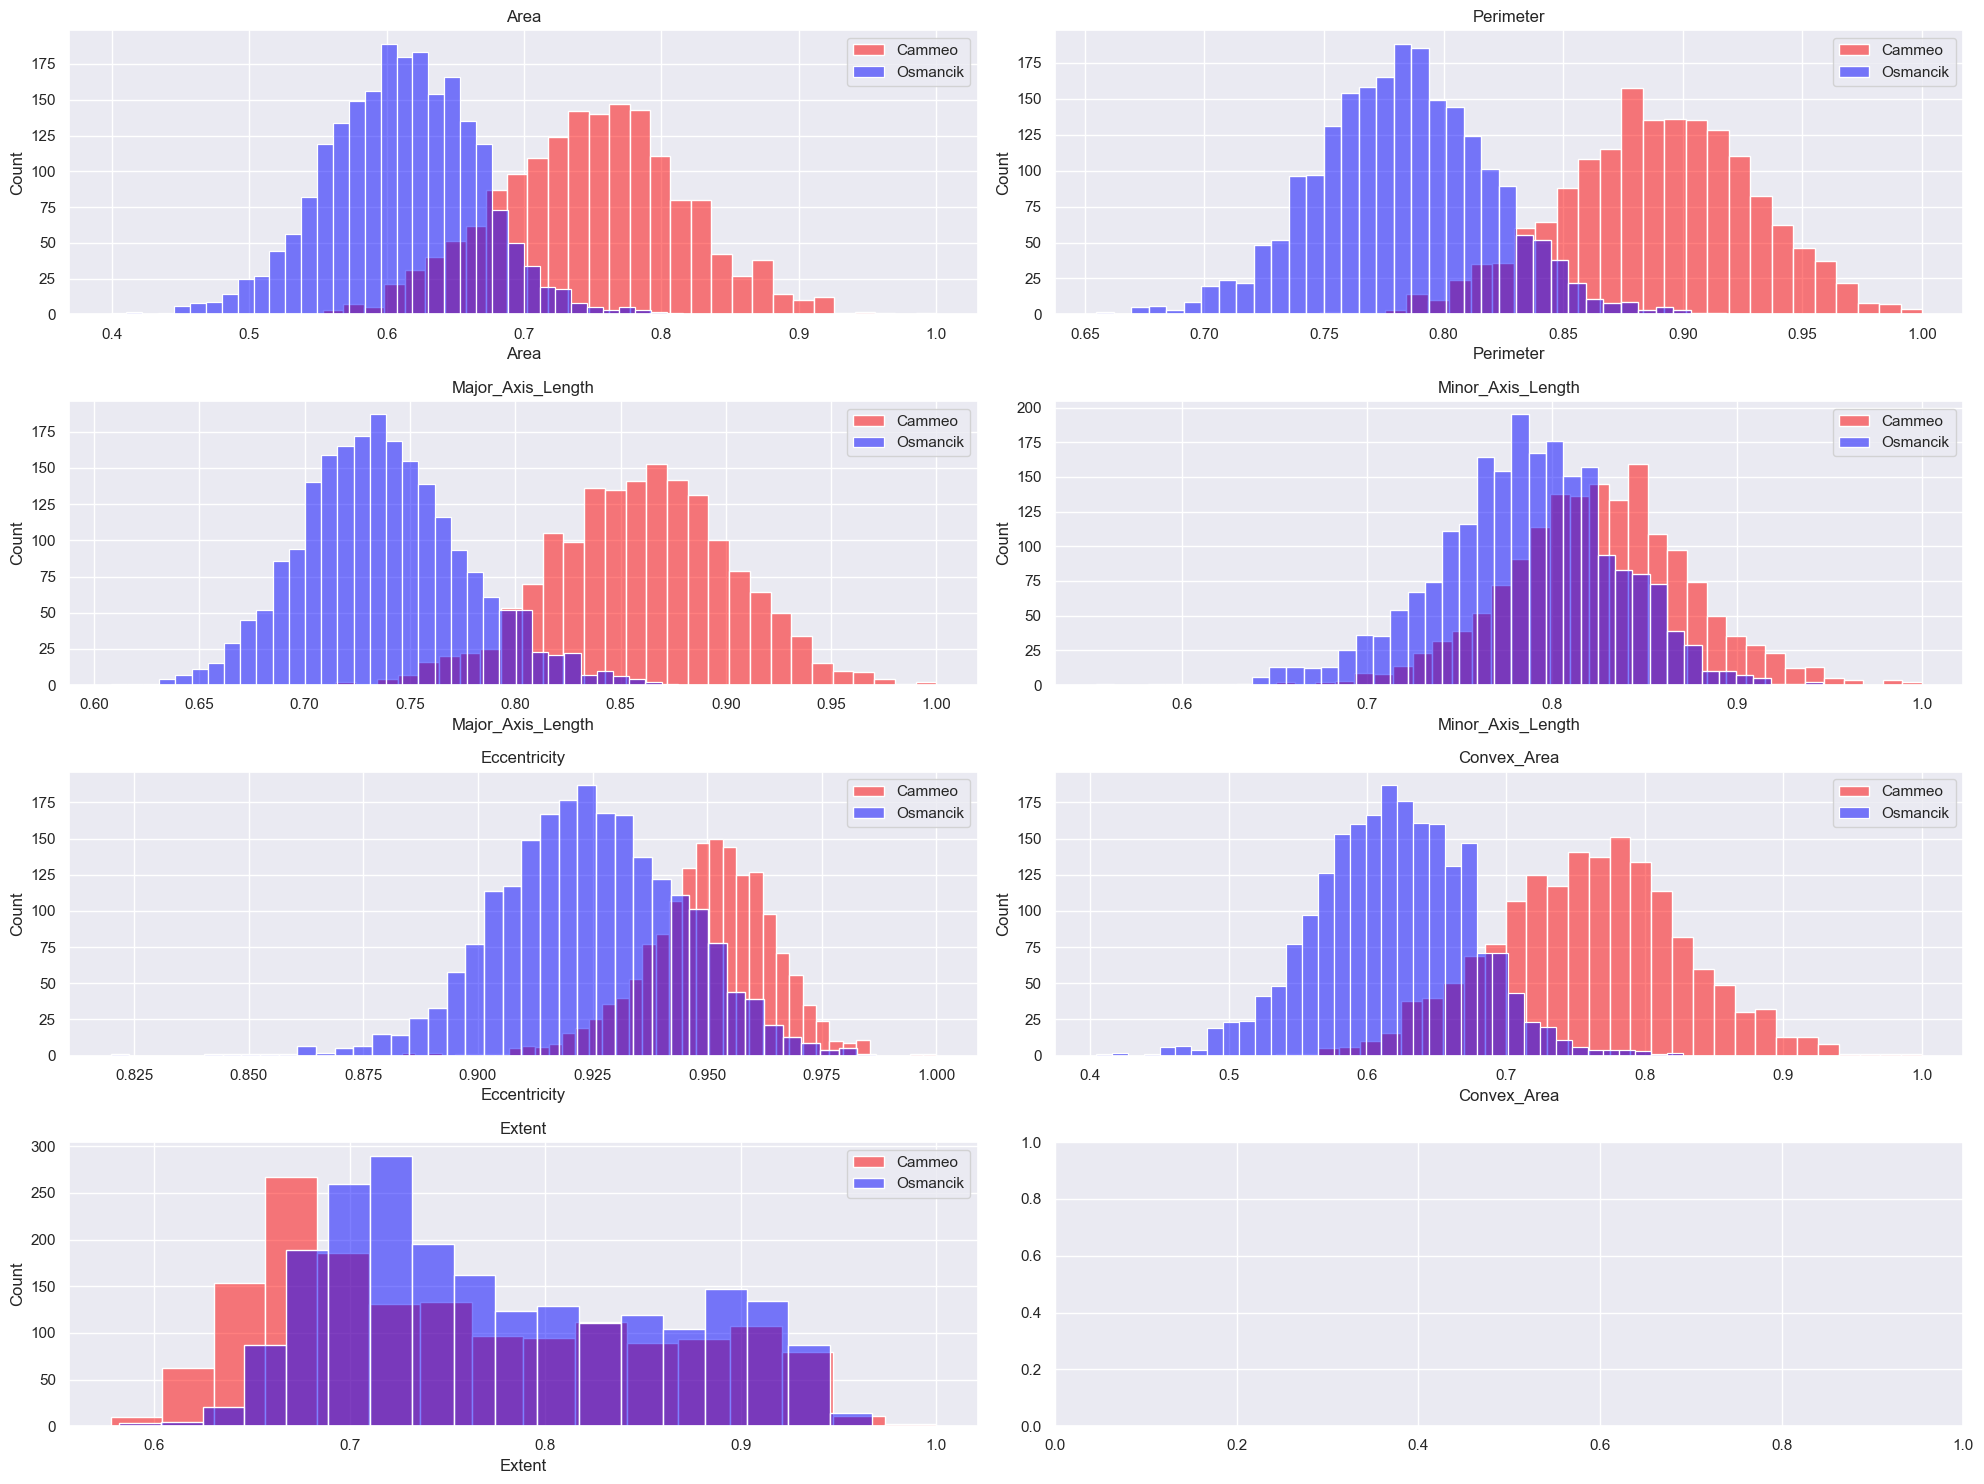

In [51]:
# Create the filtering condition for Class
filter=(df['Class']==1)

fig, axs = plt.subplots(4, 2, figsize=(20, 15))
axs = axs.flatten()

for i in range(X.shape[1]):
    sns.histplot(data=df.loc[filter,var_name[i]], ax=axs[i], color="red", alpha=0.5)
    sns.histplot(data=df.loc[~filter,var_name[i]], ax=axs[i], color="blue", alpha=0.5)
    axs[i].set_title(var_name[i])
    axs[i].legend(['Cammeo', 'Osmancik'])

fig.tight_layout()
plt.show()

# Single Input Logistic Regression

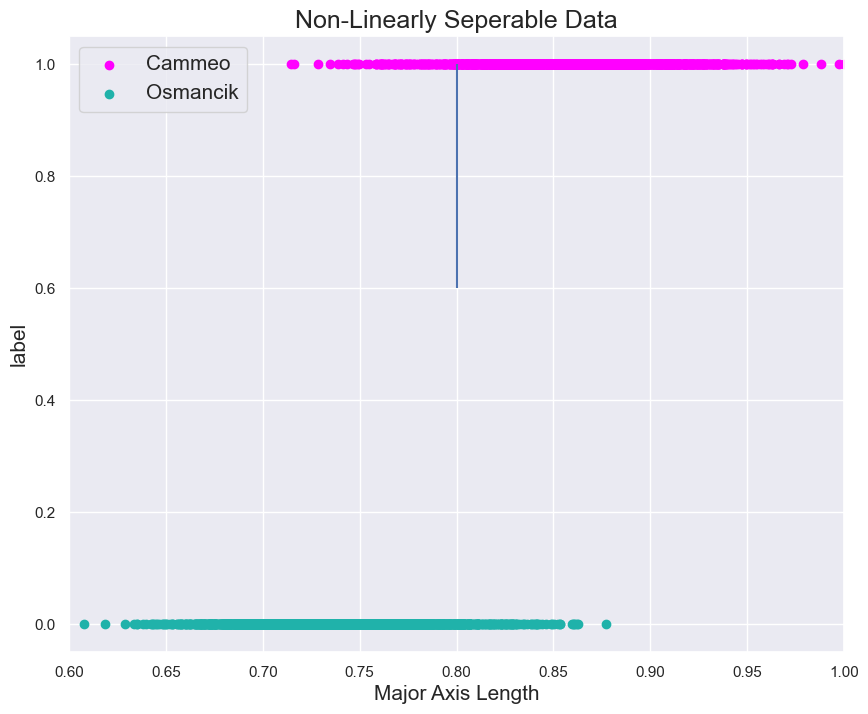

In [54]:
# Based on the overlapping histgram, we will first use Major_Axis_Length as the feature input to predict the  rice category.

cammeo=df[df.Class==1]
osmancik=df[df.Class==0]

plt.figure(figsize = (10, 8))
plt.xlim((0.6,1))
plt.scatter(cammeo.Major_Axis_Length, 
            np.ones(cammeo.shape[0]),
            color = "magenta", 
            label = "Cammeo")
plt.scatter(osmancik.Major_Axis_Length, 
            np.zeros(osmancik.shape[0]), 
            color = "lightseagreen", 
            label = "Osmancik")
plt.vlines(0.8,0.6,1.0)
plt.xlabel("Major Axis Length", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()


In [33]:
# define the Sigmoid function 
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [34]:
class SingleNeuron(object):
    """
    A class used to represent a single artificial neuron. 

    ...

    Attributes
    ----------
    activation_function : function
        The activation function applied to the preactivation linear combination.
    
    cost_function : function
        The cost function used to measure model performance.

    w_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry being the bias. 
        This attribute is created when the train method is called.

    errors_: list
        A list containing the mean sqaured error computed after each iteration 
        of stochastic gradient descent per epoch. 

    Methods
    -------
    train(self, X, y, alpha = 0.005, epochs = 50)
        Iterates the stochastic gradient descent algorithm through each sample 
        a total of epochs number of times with learning rate alpha. The data 
        used consists of feature vectors X and associated labels y. 

    predict(self, X)
        Uses the weights and bias, the feature vectors in X, and the 
        activation_function to make a y_hat prediction on each feature vector. 
    """
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    def train(self, X, y, alpha = 0.005, epochs = 50):
   
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error
                #errors += .5*((self.predict(xi) - target)**2)
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    def predict(self, X):
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

In [55]:
def cross_entropy_loss(y_hat, y):
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

In [ ]:
node = SingleNeuron(sigmoid, cross_entropy_loss)

X = df.Major_Axis_Length.values
X = X.reshape(-1,1)
y = df.Class.values
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

node.train(X_train, y_train, alpha = 0.01, epochs = 10_000)

Now that we have trained the variable node, we can now visualize the binary cross entropy loss over each epoch by plotting the values in the SingleNeuron.errors_ attribute. This can be done by running the following code in the cell below. 

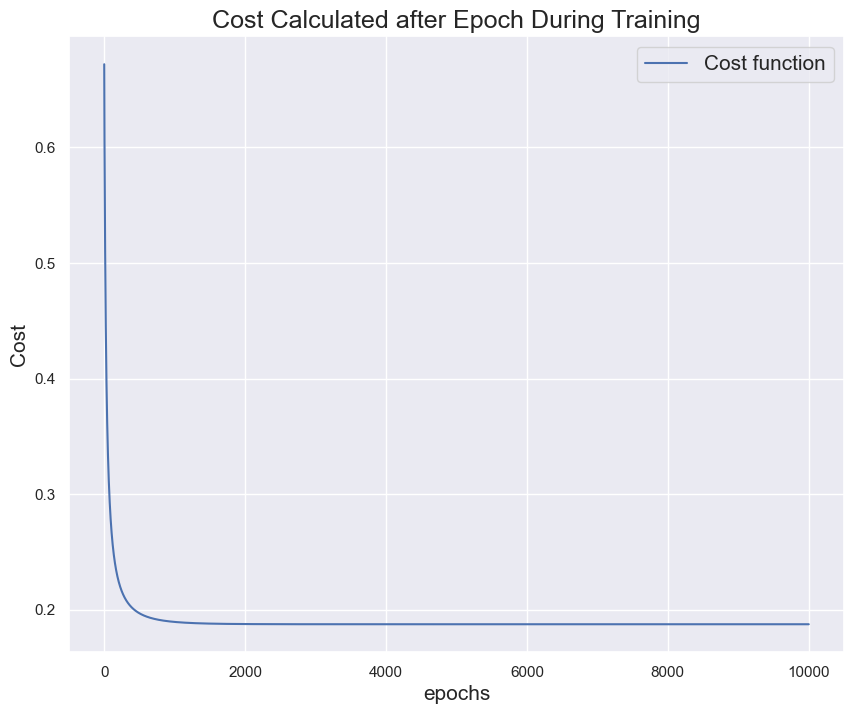

In [56]:
node.plot_cost_function()
plt.show()

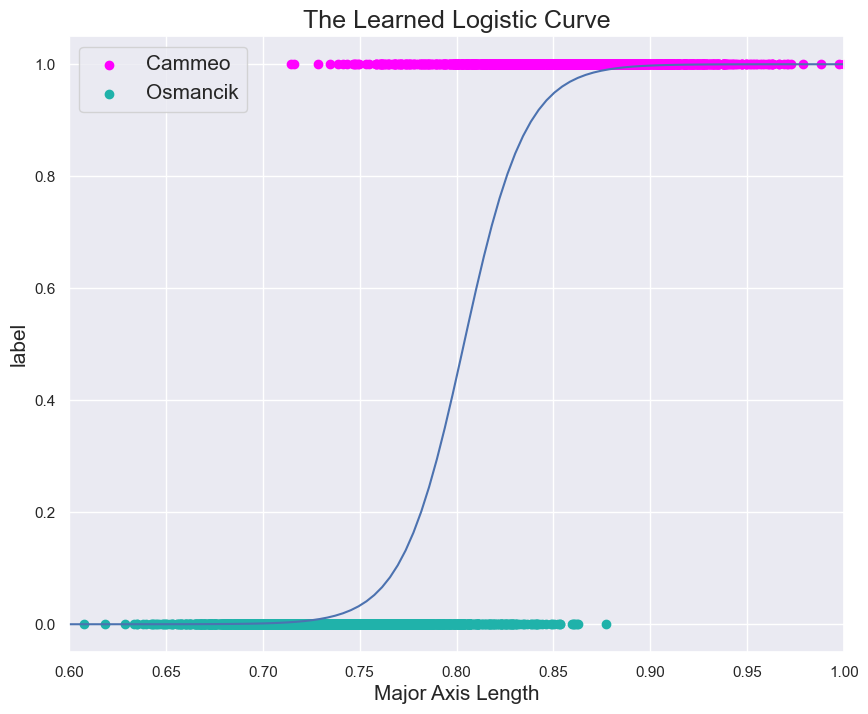

In [58]:
plt.figure(figsize = (10, 8))
plt.xlim((0.6,1))
plt.scatter(cammeo.Major_Axis_Length, 
            np.ones(cammeo.shape[0]),
            color = "magenta", 
            label = "Cammeo")
plt.scatter(osmancik.Major_Axis_Length, 
            np.zeros(osmancik.shape[0]), 
            color = "lightseagreen", 
            label = "Osmancik")

domain = np.linspace(0.6, 1, 100)
plt.plot(domain, node.predict(domain.reshape(-1, 1)))
plt.xlabel("Major Axis Length", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("The Learned Logistic Curve", fontsize = 18)
plt.show()

In [59]:
node.predict(X_test)

array([2.29985082e-01, 3.74369730e-02, 6.10701092e-02, 9.40055992e-01,
       7.19326225e-03, 7.09593175e-01, 1.11967823e-02, 8.89056646e-01,
       9.96458936e-01, 7.36508632e-01, 3.36237840e-01, 9.99532845e-01,
       8.81408092e-01, 1.18135073e-02, 9.94404824e-01, 9.99492654e-01,
       3.72619283e-03, 8.83784099e-02, 3.56316142e-01, 9.51031646e-01,
       5.52967322e-01, 7.31308276e-01, 1.34798244e-01, 6.03944613e-03,
       3.22495473e-01, 8.42211591e-03, 7.17031505e-02, 2.05345938e-02,
       9.45952038e-01, 5.84111696e-03, 1.06354785e-02, 9.31578157e-03,
       7.87309955e-02, 9.51054206e-01, 5.34744454e-04, 1.01000777e-03,
       1.95799770e-03, 3.00473802e-01, 9.99275509e-01, 7.54696643e-01,
       9.93517858e-01, 9.45411869e-01, 1.16546903e-03, 8.89303697e-04,
       9.99584765e-01, 4.75941497e-01, 1.25518782e-04, 4.89172079e-04,
       1.44172905e-02, 8.54807909e-04, 4.38836219e-02, 1.69438338e-04,
       8.82767133e-01, 8.60943311e-01, 1.50535320e-03, 9.98617415e-01,
      

In [60]:
np.rint(node.predict(X_test)) != y_test

array([ True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [61]:
classification_error = (np.rint(node.predict(X_test)) != y_test).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y_test)}")

Classification Error = 0.06955380577427822


This is a great classification error on our training data! We can now view our decision boundary implied by the trained weights and bias by running the following code in the cell below.

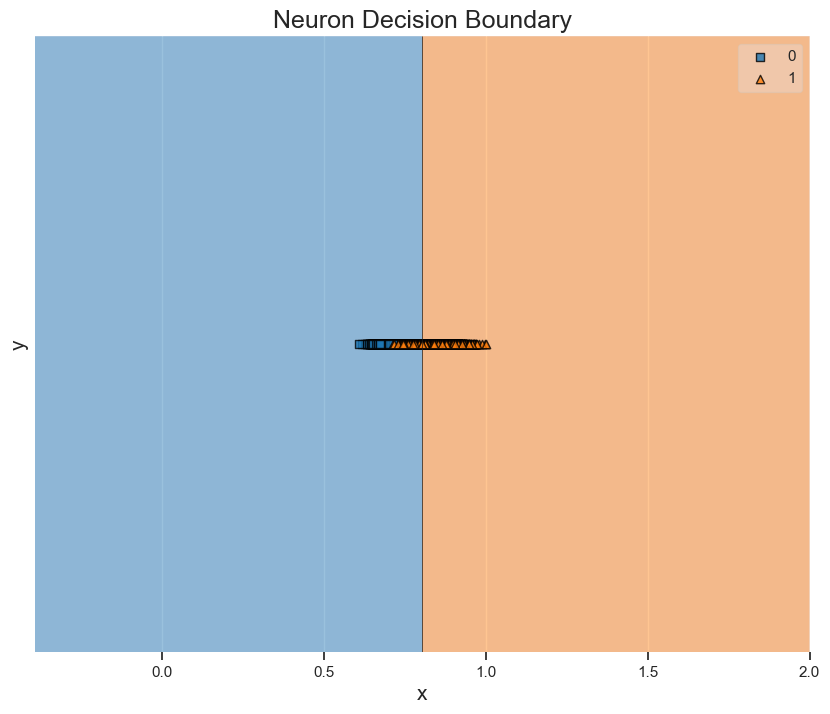

In [66]:
# transform the y type from float into integer
y = y.astype(int) 
node.plot_decision_boundary(X, y)
plt.show()

# Multiple Input Logistic Regression

In [68]:
# Based on the overlapping histgram, we decided to use Major_Axis_Length and Perimeter as input features.

node_two=SingleNeuron(sigmoid,cross_entropy_loss)

X=df[['Major_Axis_Length','Perimeter']].values
y=df.Class.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

node_two.train(X_train, y_train, alpha = 0.01, epochs = 10_000)

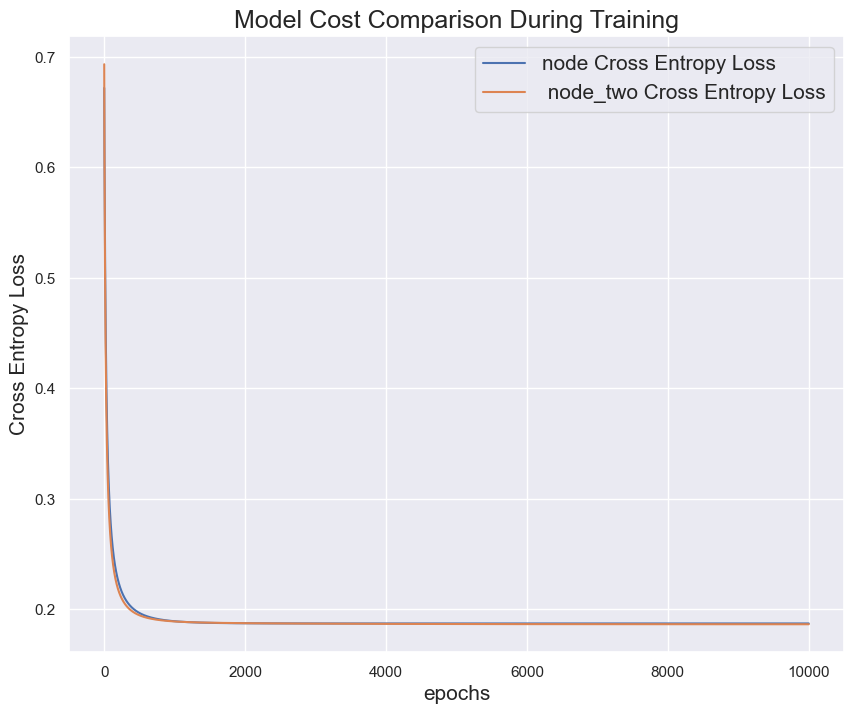

In [72]:
plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.errors_) + 1), 
         node.errors_,
         label = "node Cross Entropy Loss")
plt.plot(range(1, len(node_two.errors_) + 1), 
         node_two.errors_,
         label = " node_two Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)

plt.show()

In [76]:
node_two.predict(X_test)

array([2.51316177e-01, 3.73783793e-02, 6.90445406e-02, 9.31487665e-01,
       5.64771849e-03, 6.89809504e-01, 1.10458475e-02, 8.92136571e-01,
       9.96114231e-01, 6.82253026e-01, 2.84300223e-01, 9.99558622e-01,
       8.83026218e-01, 1.43930130e-02, 9.93707862e-01, 9.99468533e-01,
       3.63105209e-03, 7.60555945e-02, 3.51251839e-01, 9.50429307e-01,
       5.54733755e-01, 7.26354199e-01, 1.31059570e-01, 5.84891695e-03,
       3.66644215e-01, 8.30329009e-03, 6.67429822e-02, 2.30370817e-02,
       9.38787121e-01, 5.63834129e-03, 1.14775335e-02, 9.74100094e-03,
       6.85743587e-02, 9.51605042e-01, 2.98598592e-04, 9.90451638e-04,
       1.85822447e-03, 3.17221830e-01, 9.99324453e-01, 7.46526730e-01,
       9.94116994e-01, 9.46819256e-01, 1.13338108e-03, 9.87542666e-04,
       9.99526792e-01, 4.26596102e-01, 1.26157444e-04, 4.79927860e-04,
       1.73499546e-02, 9.08812647e-04, 4.64603836e-02, 1.55933297e-04,
       8.66654083e-01, 8.67986568e-01, 1.57839522e-03, 9.98442087e-01,
      

In [77]:
np.rint(node_two.predict(X_test))!=y_test

array([ True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [80]:
classification_error=(np.rint(node_two.predict(X_test))!=y_test).astype(int)
print(f"classification_error is {sum(classification_error)/len(y_test)}")

classification_error is 0.06430446194225722


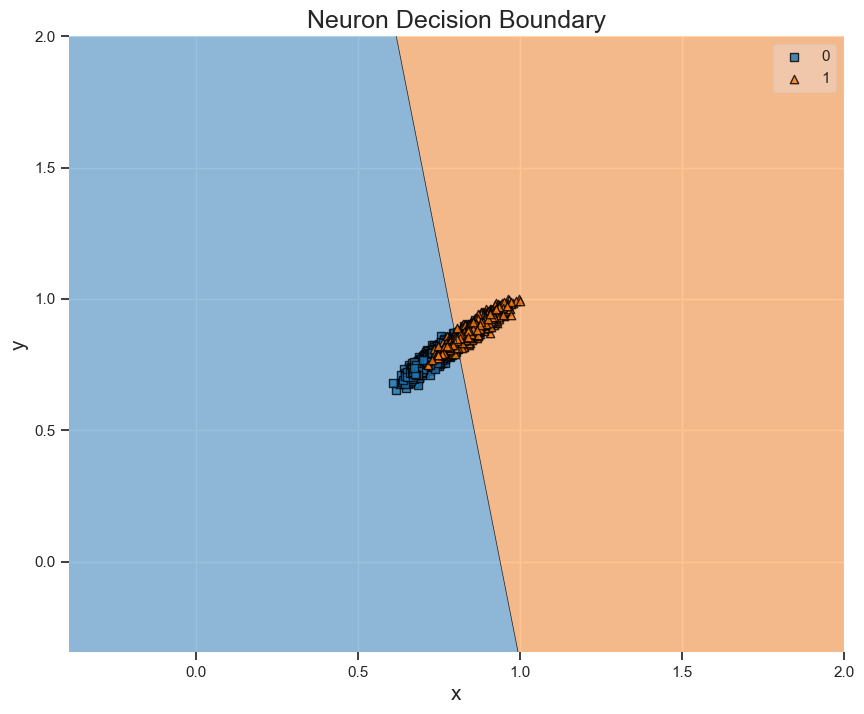

In [73]:
y=y.astype(int)
node_two.plot_decision_boundary(X, y)

# Conclusion and Discussion

The model evaluation shows that logistic regression is capable of predicting the type of rice with a very high accuracy. A summary of the results obtained is:

1. The logistic regression of single input is able to achieve a testing accuracy of 93%.
2. The logistic regression of multiple inputs is able to achieve a testing accuracy of 94%.